<a href="https://colab.research.google.com/github/Felipe0Parra/IO/blob/main/IO_PARCIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrega de la parte práctica - Parcial Instrumentos Ópticos

### Librerías

In [ ]:
import numpy as np
import scipy as sp
from scipy.fft import fft2
from scipy.fft import ifft2
from scipy.fft import fftfreq
from scipy.fft import fftshift, ifftshift
import imageio
import PIL
from PIL import Image, ImageFilter, ImageDraw, ImageFont
import cv2

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from matplotlib.animation import PillowWriter
import pint

from PIL import Image

u = pint.UnitRegistry()

## Funciones auxiliares

Abrir URLs:

In [ ]:
def URL_ADAP(URL):
    URL = str(URL)
    URL2 = URL.replace('\\', '/')
    return URL2

Normalizar una matriz:

In [ ]:
def normalize_image(image):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return normalized_image

## Microscópio

Imagen en el foco anterior del primer lente:

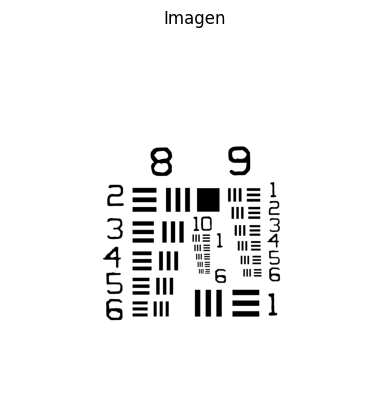

In [ ]:
USAF = cv2.imread(URL_ADAP(r'C:\Users\Felipe\Pictures\Optica_Proyecto\USAF_3000px_cl.png'), 0)

plt.figure()
plt.imshow(USAF, cmap = 'gray')
plt.title('Imagen')
plt.axis('off')
plt.show()

In [ ]:
imagen = USAF

alto, ancho = imagen.shape
tamaño_cuadrado = max(alto, ancho)

padding_alto = (tamaño_cuadrado - alto) // 2
padding_ancho = (tamaño_cuadrado - ancho) // 2

padding = ((padding_alto, tamaño_cuadrado - alto - padding_alto),
           (padding_ancho, tamaño_cuadrado - ancho - padding_ancho))

imagen_cuadrada = np.pad(imagen, padding, mode = 'constant', constant_values = 0)

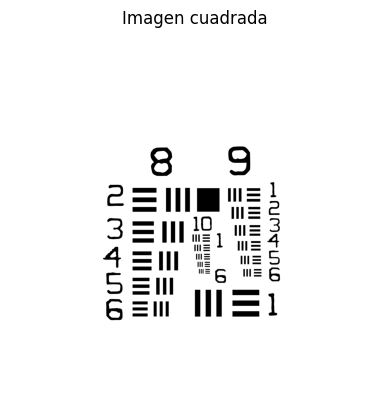

In [ ]:
plt.imshow(imagen_cuadrada, cmap = 'gray')
plt.title('Imagen cuadrada')
plt.axis('off')
plt.show()

In [ ]:
print(f"Tamaño en pixeles de la imagen = {np.shape(imagen_cuadrada)}")

Tamaño en pixeles de la imagen = (3000, 3000)


Transformada de Fourier en el foco posterior de la primer lente:

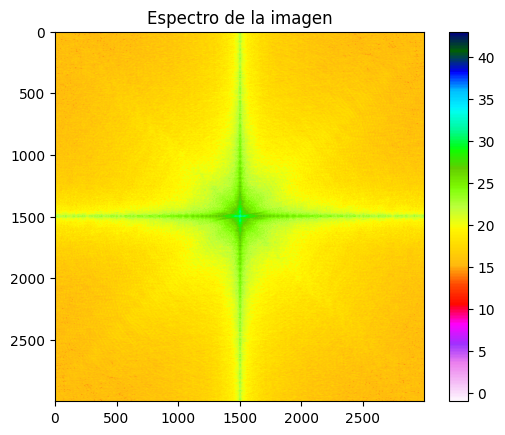

In [ ]:
fft_USAF = fftshift(fft2(imagen_cuadrada))
patrón_USAF = np.log(0.0001+ np.abs(fft_USAF)**2)

plt.imshow(patrón_USAF, cmap = 'gist_ncar_r')
plt.title('Espectro de la imagen')
plt.colorbar()
plt.show()

Una pupila para bloquear frecuencias por encima del limite dado por el sensor digital, pero ¿Cómo se cual debe ser el tamaño de la pupila?

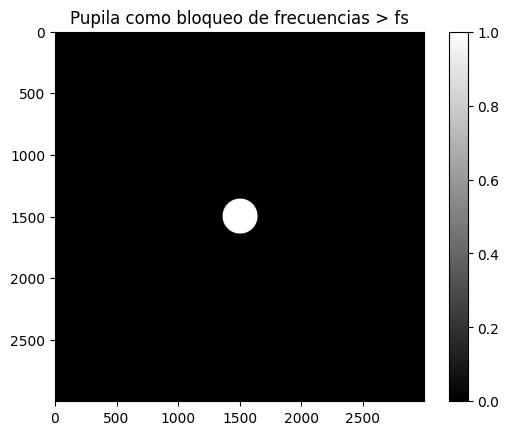

In [ ]:
pupila_USAF = np.zeros(np.shape(imagen_cuadrada), dtype = "uint8")
coordx = int(np.shape(imagen_cuadrada)[0]/2)
coordy = int(np.shape(imagen_cuadrada)[1]/2)
cv2.circle(pupila_USAF, (coordy, coordx), 142, 1, -1)

plt.imshow(pupila_USAF, cmap = 'gray')
plt.title('Pupila como bloqueo de frecuencias > fs')
plt.colorbar()
plt.show()

Ahora mostramos la reconstrucción que hace el lente de tubo con transformada directa de Fourier de la multiplicación del espectro con la pupila.

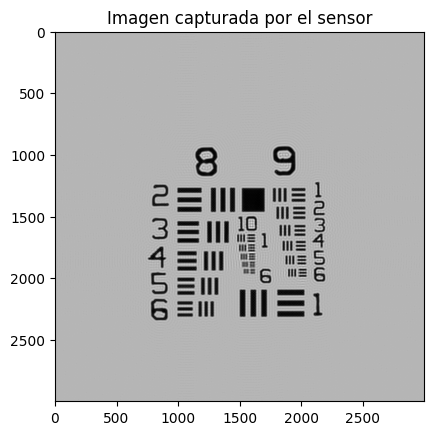

In [ ]:
imagen_reconstruida = ifft2(pupila_USAF * fft_USAF)

plt.imshow(np.abs(imagen_reconstruida), cmap = 'gray')
plt.title('Imagen capturada por el sensor')
plt.axis()
plt.show()

# Holografía

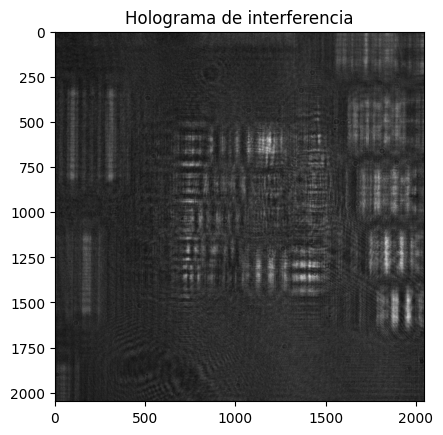

In [ ]:
Holo_inter = cv2.imread(URL_ADAP(r'C:\Users\Felipe\Pictures\Optica_Proyecto\Holograma de interferencia.tiff'), 0)

plt.figure()
plt.imshow(Holo_inter, cmap = 'gray')
plt.title('Holograma de interferencia')
plt.show()

In [ ]:
print(f"Tamaño de la imagen del holograma de interferometría: {np.shape(Holo_inter)}")

Tamaño de la imagen del holograma de interferometría: (2048, 2048)


Veamos que hay en la transformada de Fourier

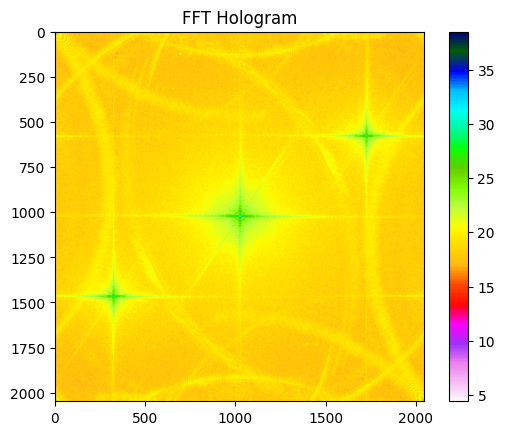

In [ ]:
fft_Holo = fftshift(fft2(Holo_inter))
patron_Holo = np.log(0.0001 + np.abs(fft_Holo)**2)

plt.imshow(patron_Holo, cmap = 'gist_ncar_r')
plt.title('FFT Hologram')
plt.colorbar()
plt.show()

In [ ]:
patron_norm = normalize_image(patron_Holo)

## Encontremos los puntos exactos

In [ ]:
umbral = np.max(np.abs(patron_norm)) * 0.85   # Valor para el cual garantizamos que solo los puntos mas luminosos son observables

picos = np.argwhere(patron_norm > umbral)
valores_picos = patron_norm[picos[:, 0], picos[:, 1]]  # Me muestra el valor en las coordenadas indentificadas

# Convertir coordenadas a frecuencias normalizadas
filas, columnas = patron_norm.shape
frecuencias_x = picos[:, 1]
frecuencias_y = picos[:, 0]
frecuencias = np.column_stack((frecuencias_x, frecuencias_y))

# Imprimir coordenadas y valores de los picos
print("Picos detectados:")
for i, (f, v) in enumerate(zip(frecuencias, valores_picos)):
    print(f"Pico {i + 1}: Frecuencia en pixeles (x, y) = ({f[0]:.4f}, {f[1]:.4f}), Intensidad = {v:.2f}")

Picos detectados:
Pico 1: Frecuencia en pixeles (x, y) = (1723.0000, 580.0000), Intensidad = 0.86
Pico 2: Frecuencia en pixeles (x, y) = (1024.0000, 1024.0000), Intensidad = 1.00
Pico 3: Frecuencia en pixeles (x, y) = (325.0000, 1468.0000), Intensidad = 0.86


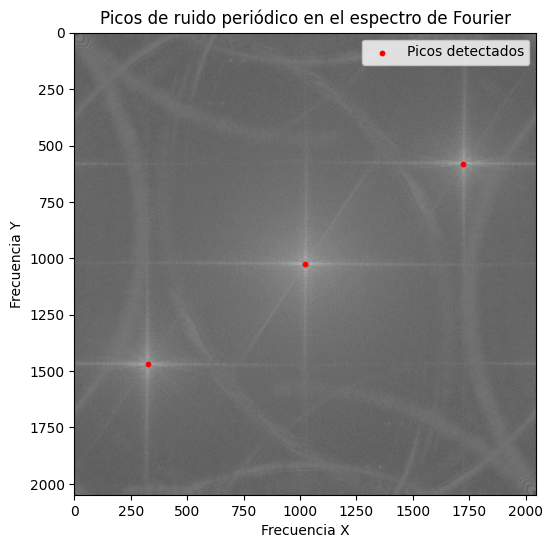

In [ ]:
# Mostrar el espectro con los picos detectados
plt.figure(figsize = (8, 6))
plt.imshow(patron_norm, cmap = 'gray', extent = (0, 2048, 2048, 0))
plt.scatter(frecuencias_x, frecuencias_y, color = 'red', s = 10, label = 'Picos detectados')
plt.title('Picos de ruido periódico en el espectro de Fourier')
plt.xlabel('Frecuencia X')
plt.ylabel('Frecuencia Y')
plt.legend()
plt.show()

Necesito entonces quedarme solo con una de los destellos fuera del centro:

Veamos si funciona:

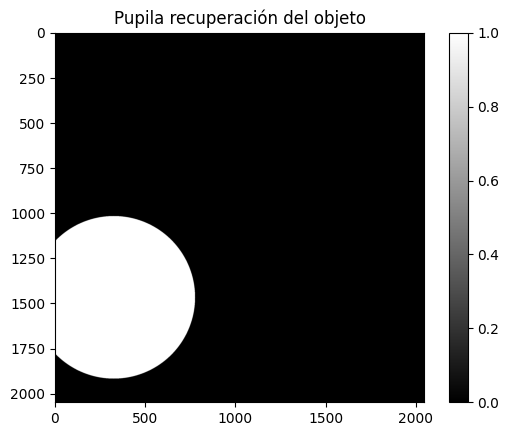

In [ ]:
pupila_HOLO = np.zeros((np.shape(patron_Holo)))


cv2.circle(pupila_HOLO, (325, 1468), 450, 1, -1)

plt.imshow(pupila_HOLO, cmap = 'gray')
plt.title('Pupila recuperación del objeto')
plt.colorbar()
plt.show()

Veamos si con el espectro en esa posición se reconstruye la imagen, a mi personalmente me parece raro:

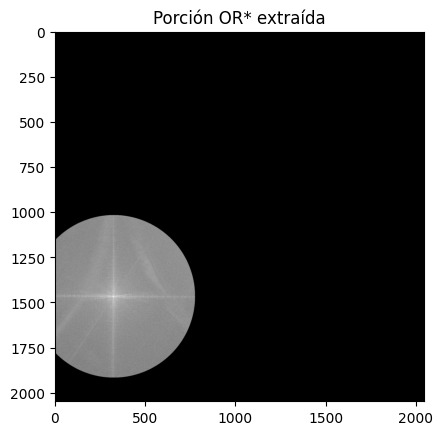

In [ ]:
plt.imshow(np.abs(pupila_HOLO * patron_Holo), cmap = 'gray')
plt.title('Porción OR* extraída')
plt.show()

## Usando la pupila

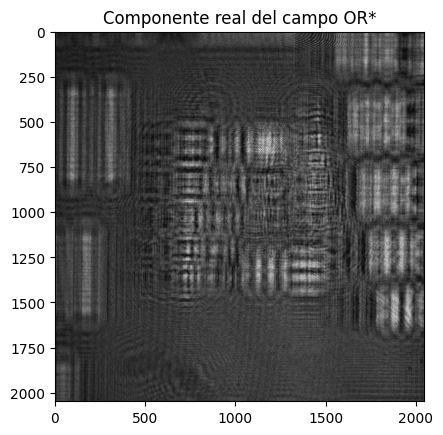

In [ ]:
recons_HOLO = ifft2(pupila_HOLO * fft_Holo)

plt.imshow(np.abs(recons_HOLO), cmap = 'gray')
plt.title('Componente real del campo OR*')
plt.show()

In [ ]:
print(f"Tamaño de la imagen del objeto recuperada: {np.shape(recons_HOLO)}")

Tamaño de la imagen del objeto recuperada: (2048, 2048)


## Usando propagación del espectro angular inversa

In [ ]:
xp = np.shape(recons_HOLO)[0]
yp = np.shape(recons_HOLO)[1]

l_planex = 7.0656   # mm
l_planey = 7.0656   # mm

x_pea = np.linspace(0, l_planex, xp)
y_pea = np.linspace(0, l_planey, yp)

xv_pea, yv_pea = np.meshgrid(x_pea, y_pea)

In [ ]:
lam = 632.80e-6  # mm

In [ ]:
def compute_A(UT, xv, yv, lam, z):
    A = fft2(UT)         # Campo U
    kx = 2 * np.pi * fftfreq(len(x_pea), np.diff(x_pea)[0])
    ky = 2 * np.pi * fftfreq(len(y_pea), np.diff(y_pea)[0])
    kxv, kyv = np.meshgrid(kx, ky)
    k = 2 * np.pi/lam
    return ifft2(A*np.exp(-1j*z*np.sqrt(k**2-kxv**2-kyv**2))) # Con su respectivo menos para denotar onda esferica convergente en el PEA inverso

Ejecutando el PEA inverso:

Hay que eliminar la modulación lineal de fase para evitar que se nos desplace.

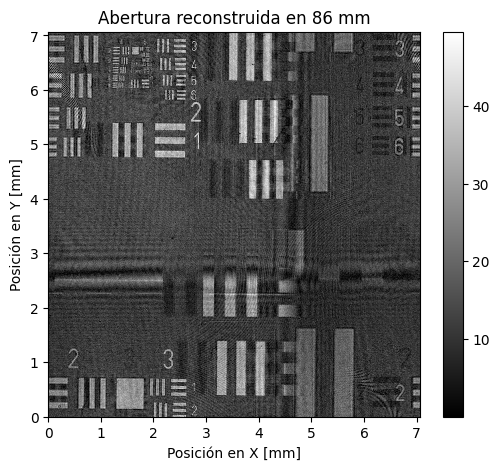

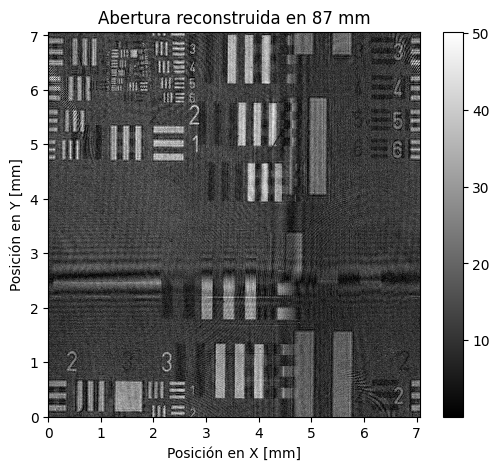

In [ ]:
cant_imgs = 1
z_min = 86
z_max = 87

for o in range(z_min, z_max + 1, int((z_max-z_min)/cant_imgs)):
    U_r0 = compute_A(recons_HOLO, xv_pea, yv_pea, lam, o)
    U_r2 = np.flip(U_r0, axis = 0)
    plt.figure(figsize = (6,5))
    malla_abertura = plt.pcolormesh(xv_pea, yv_pea, np.abs(U_r2), cmap = 'gray')
    plt.colorbar(malla_abertura)
    plt.axis()
    plt.title(f'Abertura reconstruida en {o} mm')
    plt.xlabel('Posición en X [mm]')
    plt.ylabel('Posición en Y [mm]')
    plt.show()

## Desplazando la imagen

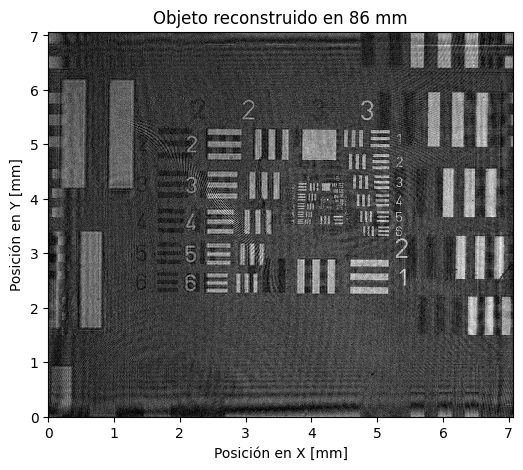

In [ ]:
U_r0 = compute_A(recons_HOLO, xv_pea, yv_pea, lam, 86)
U_r2 = np.flip(U_r0, axis = 0)
U_r3 = np.roll(U_r2, shift = 743, axis = 1)
U_r4 = np.roll(U_r3, shift = -725, axis = 0)
plt.figure(figsize = (6,5))
plt.pcolormesh(xv_pea, yv_pea, np.abs(U_r4), cmap = 'gray')
plt.axis()
plt.title('Objeto reconstruido en 86 mm')
plt.xlabel('Posición en X [mm]')
plt.ylabel('Posición en Y [mm]')
plt.show()

In [ ]:
np.shape(U_r4)

(2048, 2048)

In [ ]:
theta_x = (-3.589230213 * np.pi)/180
theta_y = (-2.278964397 * np.pi)/180
theta_z = (4.25323 * np.pi)/180

## Implementación digital de onda de contrafase

In [ ]:
campo_Nmodul = recons_HOLO * np.exp(1j * 2 * np.pi * (1/lam) * (x_pea * np.sin(theta_x) + y_pea * np.sin(theta_y)))

## PEA sin control de desfase

## PEA con control de desfase

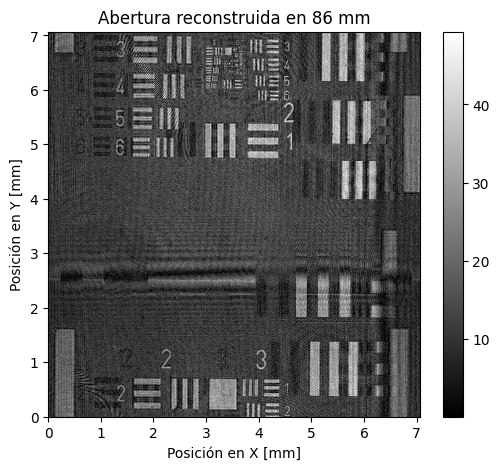

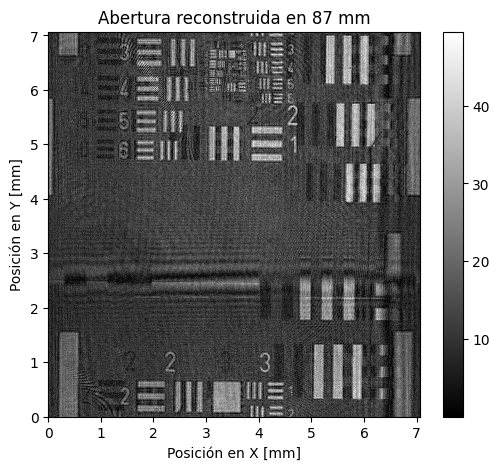

In [ ]:
cant_imgs = 1
z_min = 86
z_max = 87

for o in range(z_min, z_max + 1, int((z_max-z_min)/cant_imgs)):
    U_r0 = compute_A(campo_Nmodul, xv_pea, yv_pea, lam, o)
    U_r2 = np.flip(U_r0, axis = 0)
    plt.figure(figsize = (6,5))
    malla_abertura = plt.pcolormesh(xv_pea, yv_pea, np.abs(U_r2), cmap = 'gray')
    plt.colorbar(malla_abertura)
    plt.axis()
    plt.title(f'Abertura reconstruida en {o} mm')
    plt.xlabel('Posición en X [mm]')
    plt.ylabel('Posición en Y [mm]')
    plt.show()